In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import csv
import re

In [2]:
! pip install transformers datasets

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 311 kB 50.3 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 
     |████████████████████████████████| 895 kB 41.4 MB/s 
     |████████████████████████████████| 6.5 MB 37.7 MB/s 
     |████████████████████████████████| 134 kB 41.7 MB/s 
     |████████████████████████████████| 212 kB 17.6 MB/s 
     |████████████████████████████████| 1.1 MB 39.7 MB/s 
     |████████████████████████████████| 271 kB 41.6 MB/s 
     |████████████████████████████████| 144 kB 40.8 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
df = pd.read_csv('/content/re_dataset_three_labels.csv')

In [4]:
df.head()

Label                                              Tweet
0      2  - Dia sendiri yang ngiklanin promo cashback di...
1      3  - disaat semua cowok berusaha melacak perhatia...
2      2  - kampret kan kalo typo-nya di email kantor ke...
3      2  - Mending makan disini lebih murah, buang-buan...
4      2  /biarin oppa masukim vibrator ke memek/ oppa k...

In [5]:
df.shape

(2016, 2)

Text(0.5, 1.0, 'Train Label Frequency')

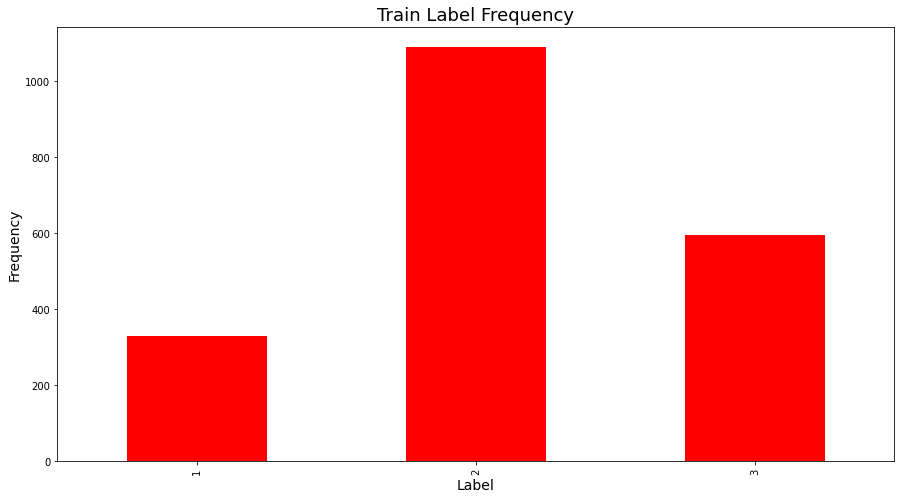

In [6]:
df['Label'].value_counts().sort_index().plot(kind = 'bar', figsize =(15,8), colormap='hsv')
plt.xlabel('Label',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title("Train Label Frequency",fontsize=18)

In [7]:
df['Label'].value_counts()

2    1090
3     595
1     331
Name: Label, dtype: int64

# Data Pre-Processing

In [8]:
label = []
sentences = []

In [9]:
def convert_label(x):
  if x == 1:
    return 0
  elif x==2:
    return 1
  elif x==3:
    return 2
df['Label'] = df['Label'].apply(convert_label)
df['Label'].value_counts()

1    1090
2     595
0     331
Name: Label, dtype: int64

In [10]:
import re

def preproc(sentence):
  # remove non char
  x = sentence
  x = x.lower()
  x = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',x) #remove symbol
  x = re.sub('[\s]+', ' ', x) #remove additional whitespace
  x = re.sub(r'[^\w\s]','',x) #remove punctuation
  x = x.strip() #remove any space at the start and the end
  words = x

  return words

df['Tweet'] = df["Tweet"].apply(preproc)

In [11]:
for index, row in df.iterrows():
    label.append(row['Label'])
    sentences.append(row['Tweet'])

## Kamus alay

In [13]:
kamusalay = pd.read_csv('kamusalay.csv')
kamusalay.columns = ['alay', 'normal']
kamusalay.head()

alay   normal
0    ajj     saja
1   akoh      aku
2  amaca  ah masa
3   amuh     kamu
4    aph      apa

In [14]:
with open('kamusalay.csv', 'r') as lemmas:
    lematizer = csv.reader(lemmas, delimiter = ',')

    tuples = []

    for tokens in lematizer:
        tuples.append(tuple([tokens[0], tokens[1]]))
    result = dict(tuples)

    print(result)

{'ajh': 'saja', 'ajj': 'saja', 'akoh': 'aku', 'amaca': 'ah masa', 'amuh': 'kamu', 'aph': 'apa', 'apose': 'apa', 'apz': 'apa', 'aq': 'saya', 'baryaw': 'sabar ya', 'baryw': 'sabar ya', 'bryaw': 'sabar ya', 'bryw': 'sabar ya', 'bay': 'selamat tinggal', 'besoq': 'besok', 'beud': 'banget', 'bhay': 'selamat tinggal', 'bisya': 'bisa', 'biza': 'bisa', 'bntr': 'sebentar', 'bokap': 'ayah', 'bkap': 'ayah', 'bkp': 'ayah', 'bokaps': 'ayah', 'bokapz': 'ayah', 'bs': 'bisa', 'bsa': 'bisa', 'bsk': 'besok', 'bsoq': 'besok', 'bte': 'bosan', 'bozen': 'bosan', 'bozn': 'bosan', 'bzn': 'bosan', 'bzen': 'bosan', 'cabut': 'pergi', 'caiank': 'sayang', 'cekola': 'sekolah', 'cekolah': 'sekolah', 'celalaw': 'selalu', 'celalu': 'selalu', 'cemungudh': 'semangat', 'cemungut': 'semangat', 'cemunguth': 'semangat', 'cibuq': 'sibuk', 'cini': 'sini', 'ciyus': 'serius', 'cll': 'selalu', 'cllu': 'selalu', 'cllw': 'selalu', 'cpe': 'capek', 'cpee': 'capek', 'cewe': 'cewek', 'cwe': 'cewek', 'cowo': 'cowok', 'cwo': 'cowok', 'da

In [15]:
text = 'ajh ajj akoh amaca amuh'

lemmatized_text = re.sub(r'\b(%s)\b' % '|'.join(result.keys()), lambda m:result.get(m.group(1), m.group(1)), text)

print(lemmatized_text)

saja saja aku ah masa kamu


## Stop Words

In [16]:
!pip install Sastrawi

     |████████████████████████████████| 209 kB 4.1 MB/s 


In [17]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stop_factory = StopWordRemoverFactory()

more_stopword = ['nya', 'yg', 'aja', 'pun', 'mas', 'mbak']
remove_stopword = ['bisa', 'boleh', 'nggak', 'ok', 'seharusnya', 'setidaknya', 'tapi', 'tidak', 'tolong']

data_stopwords = stop_factory.get_stop_words() + more_stopword

In [18]:
for words in remove_stopword:
  data_stopwords.remove(words)

In [19]:
def unique(list1):
  # insert the list to the set
  list_set = set(list1)
  # convert the set to the list and sort it
  unique_list = sorted((list(list_set)))
  for x in unique_list:
    print(x)

In [20]:
unique(data_stopwords)

ada
adalah
agak
agar
aja
akan
amat
anda
antara
anu
apakah
apalagi
atau
bagaimanapun
bagi
bahwa
begitu
belum
dahulu
dalam
dan
dapat
dari
daripada
demi
demikian
dengan
di
dia
dimana
dll
dsb
dst
dua
dulunya
guna
hal
hanya
harus
ia
ingin
ini
itu
itulah
jika
juga
kah
kami
karena
ke
kecuali
kemana
kembali
kenapa
kepada
ketika
kita
lagi
lain
maka
mari
mas
masih
mbak
melainkan
mengapa
menurut
mereka
namun
nanti
nya
oh
oleh
pada
para
pasti
pula
pun
saat
saja
sambil
sampai
saya
sebab
sebagai
sebelum
sebetulnya
secara
sedangkan
sehingga
sekitar
selagi
selain
sementara
seolah
seperti
seraya
serta
sesuatu
sesudah
setelah
seterusnya
setiap
sudah
supaya
tanpa
telah
tentang
tentu
terhadap
tetapi
toh
untuk
walau
ya
yaitu
yakni
yang
yg


## Kamus Alay + Stop Words

In [21]:
sentences[2011]

'yagimanasih anjir gue dirumah doang dari pagi karena gangerti arah jalan sini mau main juga bingung gada temen xf0 x9f x98 xad xf0 x9f xa4 xa7'

In [22]:
final_sentences = []

# Kamus alay
for sentence in sentences:
  sentence2 = re.sub(r'\b(%s)\b' % '|'.join(result.keys()), lambda m:result.get(m.group(1), m.group(1)), sentence)

  # Stop Words
  for word in data_stopwords:
    token = " " + word + " "
    sentence2 = sentence2.replace(token, " ")
  final_sentences.append(sentence2)

In [23]:
final_sentences[2011]

'yagimanasih anjir dirumah doang pagi gangerti arah jalan sini mau main bingung gada temen xf0 x9f x98 xad xf0 x9f xa4 xa7'

# Model

In [24]:
print(len(label))
print(len(final_sentences))

2016
2016


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_sentences, label, 
                                                    train_size=0.9, 
                                                    random_state=42,
                                                    stratify=label)

In [26]:
print(f"Numbers of train instances by class: {np.bincount(y_train)}")
print(f"Numbers of test instances by class: {np.bincount(y_test)}")

Numbers of train instances by class: [298 981 535]
Numbers of test instances by class: [ 33 109  60]


In [27]:
train_dataset = {'sentence': list(X_train), 'label': list(y_train)}
train_dataset = pd.DataFrame(train_dataset)
train_dataset.to_csv('train_dataset.csv', index=False)

test_dataset ={'sentence': list(X_test), 'label': list(y_test)}
test_dataset = pd.DataFrame(test_dataset)
test_dataset.to_csv('test_dataset.csv', index=False)

In [28]:
from datasets import load_dataset
data_files = {
    'train': '/content/train_dataset.csv',
    'test': '/content/test_dataset.csv'
}
dataset = load_dataset('csv', data_files=data_files)
dataset

Using custom data configuration default-28453c94118bf4e2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-28453c94118bf4e2/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1814
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 202
    })
})

In [29]:
dataset['train'][0]

{'label': 2,
 'sentence': 'user kalau busuk mawati beragama islam  takut dg dirinya sendiri ngejala gila nenek'}

In [30]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")

model = TFAutoModelForSequenceClassification.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier", num_labels=3)

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/789k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at w11wo/indonesian-roberta-base-sentiment-classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [31]:
def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True)

In [32]:
tokenized_dataset  = dataset.map(preprocess_function, batched=True)
tokenized_dataset

  0%|          | 0/2 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1814
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 202
    })
})

In [33]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_dataset['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [34]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

batch_size = 8
num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

opt = Adam(learning_rate=lr_scheduler)

In [35]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [36]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", f1_m, precision_m, recall_m]
)
history = model.fit(
          tf_train_dataset,
          validation_data=tf_validation_dataset,
          verbose=1,
          epochs=num_epochs
          )

Epoch 1/10
226/226 [==============================] - 90s 293ms/step - loss: 0.8842 - accuracy: 0.6184 - f1_m: 1.0739 - precision_m: 0.9529 - recall_m: 1.3027 - val_loss: 0.6783 - val_accuracy: 0.7030 - val_f1_m: 1.1200 - val_precision_m: 0.8980 - val_recall_m: 1.5413
Epoch 2/10
226/226 [==============================] - 63s 277ms/step - loss: 0.5623 - accuracy: 0.7716 - f1_m: 1.0243 - precision_m: 0.8889 - recall_m: 1.2420 - val_loss: 0.7982 - val_accuracy: 0.6436 - val_f1_m: 1.0724 - val_precision_m: 0.8909 - val_recall_m: 1.3846
Epoch 3/10
226/226 [==============================] - 62s 276ms/step - loss: 0.3361 - accuracy: 0.8888 - f1_m: 0.9797 - precision_m: 0.8536 - recall_m: 1.1804 - val_loss: 0.8141 - val_accuracy: 0.7030 - val_f1_m: 1.0190 - val_precision_m: 0.8437 - val_recall_m: 1.3087
Epoch 4/10
226/226 [==============================] - 63s 277ms/step - loss: 0.1981 - accuracy: 0.9264 - f1_m: 0.9527 - precision_m: 0.8433 - recall_m: 1.1147 - val_loss: 0.9429 - val_accuracy:

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
model.save_pretrained('/content/drive/MyDrive/Mini Project/indonesian-roberta-2', saved_model=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mini Project/indonesian-roberta-2/saved_model/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mini Project/indonesian-roberta-2/saved_model/1/assets


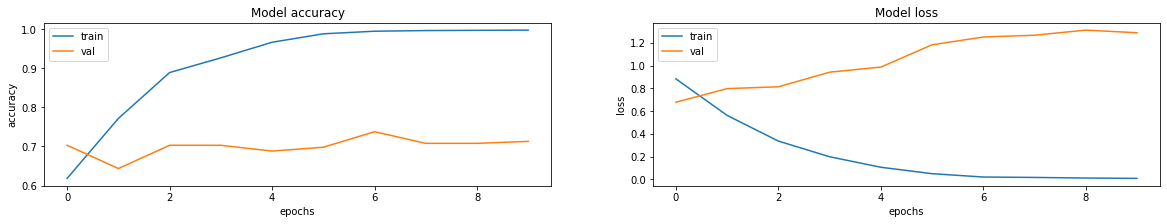

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [40]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


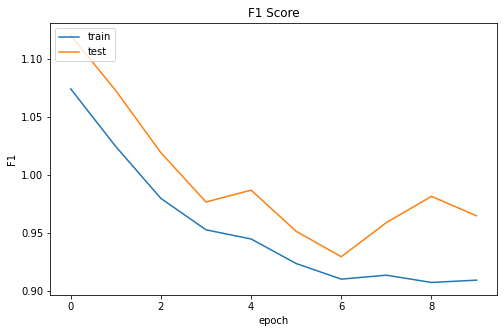

In [41]:
plt.figure(figsize=(8,5))
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

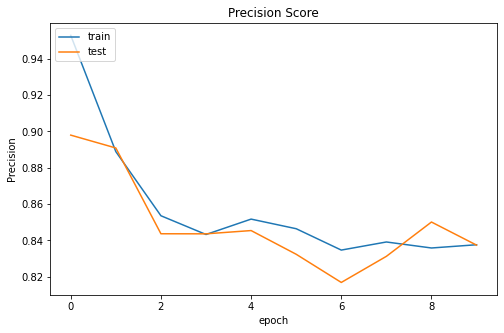

In [42]:
plt.figure(figsize=(8,5))
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision Score')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

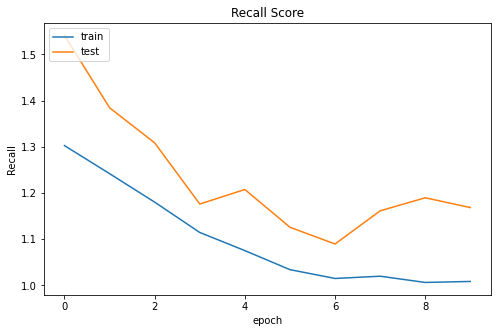

In [43]:
plt.figure(figsize=(8,5))
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall Score')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
cf = model.predict(tf_validation_dataset)

In [55]:
cf_labels = np.argmax(cf.logits, axis=1)

In [56]:
cf_labels

array([1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1,
       1, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1,
       2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1,
       2, 2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1,
       0, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0,
       2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 2, 1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 2,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 2, 2,
       2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 0, 1])

In [57]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [69]:
ks = np.array(test_dataset.label)

In [70]:
ks

array([0, 2, 2, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1,
       1, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 2, 1, 1, 0, 2, 1, 0, 0, 2, 1, 2, 2, 0, 1, 1, 1, 0, 0, 2, 1, 2,
       1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 2, 0, 2, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2,
       2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 2, 0, 1])

In [72]:
cm = confusion_matrix(y_true=ks, y_pred=cf_labels)

In [58]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [59]:
cm_plot_labels = ['0','1', '2']

Confusion matrix, without normalization
[[20 12  1]
 [16 83 10]
 [ 0 19 41]]


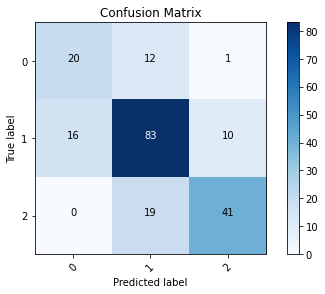

In [73]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [104]:
incorrect_0_1 = []
incorrect_0_2 = []
incorrect_1_0 = []
incorrect_1_2 = []
incorrect_2_0 = []
incorrect_2_1 = []

In [105]:
for pos, value in enumerate(cf_labels):
  if value == 0:
    if value != ks[pos]:
      if ks[pos] == 1:
        incorrect_0_1.append(pos)
      elif ks[pos] == 2:
        incorrect_0_2.append(pos)
  if value == 1:
    if value != ks[pos]:
      if ks[pos] == 0:
        incorrect_1_0.append(pos)
      elif ks[pos] == 2:
        incorrect_1_2.append(pos)
  if value == 2:
    if value != ks[pos]:
      if ks[pos] == 0:
        incorrect_2_0.append(pos)
      elif ks[pos] == 1:
        incorrect_2_1.append(pos)

In [106]:
print(incorrect_0_1)
print(incorrect_0_2)

[12, 45, 48, 69, 80, 82, 88, 108, 109, 111, 116, 142, 143, 144, 151, 172]
[]


In [107]:
print(incorrect_1_0)
print(incorrect_1_2)

[0, 7, 15, 56, 70, 79, 83, 99, 118, 134, 160, 161]
[5, 8, 11, 18, 40, 42, 47, 51, 52, 54, 60, 75, 78, 87, 102, 103, 137, 149, 195]


In [108]:
print(incorrect_2_0)
print(incorrect_2_1)

[74]
[44, 66, 91, 97, 120, 141, 147, 165, 194, 197]


In [117]:
print('Prediksi 0 (not abusive), True value 1 (abusive, but not offensive)\n')
for pos, value in enumerate(test_dataset.sentence):
  if pos in incorrect_0_1: 
    print(f'{pos}\t{value}\n')

print('==============================================================================================')
print('Prediksi 0 (not abusive), True value 2 (offensive)\n')
for pos, value in enumerate(test_dataset.sentence):
  if pos in incorrect_0_2: 
    print(f'{pos}\t{value}\n')

Prediksi 0 (not abusive), True value 1 (abusive, but not offensive)

12	user kamu bau monyet tidak

45	rt user jangan jadikan bodoh babi sial tu zikir harian  moga kurangkan jauhkan amiiin xe2 x98 xba xef xb8 x8f

48	rt user olahraga apa namanya ekstrim bungee jumping apa banci jamping iya iya banci tumpakke trail banci njamping xe2 x80 xa6

69	tahey romi menuhin tab mensyen user n ni can t contain that many monyet showeran at once xf0 x9f x98 xad xf0 x9f x98 x82

80	user sa ingat monyet mana quote ni

82	user halah tai kacang lupa kulitnya ngatain jyp

88	rt user temanmakanteman janji bakalan ngasi nyontek ujian tapi pas giliran ujian malah pura2 budek user xe2 x80 xa6

108	sinting sanca records kemarin sukses cover soundtrack wiro sableng sekarang sukses cover soundtrack mighty morphin power rangers n njuara nurl

109	kampungan sekali tidak tahu crispy rendang kalo kamu kebetulan dapet lengkoas lah crispy rendang

111	disebut norak kampungan nagita slavina ibunda ayu ting ting doakan

In [118]:
print('Prediksi 1 (abusive, but not offensive), True value 0 (not abusive)\n')
for pos, value in enumerate(test_dataset.sentence):
  if pos in incorrect_1_0: 
    print(f'{pos}\t{value}\n')

print('==============================================================================================')
print('Prediksi 1 (abusive, but not offensive), True value 2 (offensive)\n')
for pos, value in enumerate(test_dataset.sentence):
  if pos in incorrect_1_2: 
    print(f'{pos}\t{value}\n')

Prediksi 1 (abusive, but not offensive), True value 0 (not abusive)

0	user user user user user user user user cinta memang buta xf0 x9f x98 x82 terkadang cinta buat orang telinganya bagus jadi budek terkadang cinta buat orang tadinya otaknya normal jadi bloon xf0 x9f x98 x82 n nbye ah xf0 x9f x91 xb

7	amerika latin gila tiket piala dunia n nurl url

15	assalamualaikum bu risma tolong warga sya jalan kalimas udik 1c dpan rumah jl kalimas udik 1b 1 minta bantuan bu risma warga sya rumahnya roboh kshan bu risma warga sya tidak punya tempat tinggal rumahnya roboh

56	aku hbs pulang skillab hbs puyeng krn aku budek gabisa bedain suara redup jantung pas dipalpasi gmn semua terasa sama dikupingku trs pas pulang liat tl w1 ternyata jadi konser aku makin poseng

70	kata orang jawa moto picrk kuping budek rai gedek masalah dihadapi rakyat n nkalian populer dg cara hina url

79	user aku ra usah tak tutupi wis budek o mba wkwkwk

83	yah sekian pandangan awam wkwwk sekali lg cuman pandangan awam 

In [119]:
print('Prediksi 2 (offensive), True value 0 (not abusive)\n')
for pos, value in enumerate(test_dataset.sentence):
  if pos in incorrect_2_0: 
    print(f'{pos}\t{value}\n')

print('==============================================================================================')
print('Prediksi 2 (offensive), True value 1 (abusive, but not offensive)\n')
for pos, value in enumerate(test_dataset.sentence):
  if pos in incorrect_2_1: 
    print(f'{pos}\t{value}\n')

Prediksi 2 (offensive), True value 0 (not abusive)

74	rt user baru gituin sama pemain persija kayak kebakaran kumis nsuporter kok baperan nengga inget kelakuan kalian pemain xe2 x80 xa6

Prediksi 2 (offensive), True value 1 (abusive, but not offensive)

44	teko o rek n nmksdnya bukan arek tapi perek

66	user terus nalus puji butut disebut butut goblog disebut goblog

91	babi apaa sialll

97	user baca berulang ulang tetep tidak ngerti gara gara libur trus jadi goblog lama lama

120	ejekan monyet mencemari bola sepak url

141	user kek gitu kalau noona anak jalanan kamu anak gembel ya

147	user percuma tidak perlu ingetin bang user kalau orang hatinya tertanam sifat ajaran iblis orang pastin lntolerans mngadu domba tabur kebncian sara dll

165	jadi saling marah marah si syamsudin sama si ari aku sedang katanya sih si syamsudin mabuk jadinya goblog kayak wasit

194	user user user user bukan dungu idiot setambak

197	mbah berfatwa kalo ngomong asu tidak papa asal jangan diikuti kata kamu n